In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import ast #converting column values to lists post-import from csv

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords

import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv('data/recipe_data_w_target.csv')
df.head()

,Unnamed: 0,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,target_tag,target_search_term,target
0,0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","{'diabetic', 'low-calorie', 'vegetarian', 'low...",False,False,0
1,1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'shrimp'}",False,True,0
2,3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","{'side', 'vegetarian', 'italian'}",True,False,0
3,4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",{'dinner'},True,True,1
4,5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'preparation', 'des...",{'dessert'},False,False,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485306 entries, 0 to 485305
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Unnamed: 0           485306 non-null  int64 
 1   id                   485306 non-null  int64 
 2   name                 485306 non-null  object
 3   description          485306 non-null  object
 4   ingredients          485306 non-null  object
 5   ingredients_raw_str  485306 non-null  object
 6   serving_size         485306 non-null  object
 7   servings             485306 non-null  int64 
 8   steps                485306 non-null  object
 9   tags                 485306 non-null  object
 10  search_terms         485306 non-null  object
 11  target_tag           485306 non-null  bool  
 12  target_search_term   485306 non-null  bool  
 13  target               485306 non-null  int64 
dtypes: bool(2), int64(4), object(8)
memory usage: 45.4+ MB


In [4]:
def return_to_list(df, column_names):
    ''' Takes in list of names of columns containing strings and the dataframe they sit in and returns converts each column's contents into a new
    column, called '<original column name>_list', now as lists. May only work on strings that look like lists.... 
    
    Inputs:
    df = dataframe with columns being converted to lists
    column_names = list of columns whose contents need to be transformed
    
    Returns: updated dataframe
    '''
    for col in column_names:
        col_name = col + '_list'
        df[col_name] = [ast.literal_eval(x) for x in df[col] ]
    
    return df

In [5]:
col_to_list = ['ingredients', 'ingredients_raw_str', 'steps',
               'tags', 'search_terms']

In [6]:
df = return_to_list(df, col_to_list)

In [7]:
df['search_terms_list'] = df['search_terms_list'].apply(lambda x: list(x))

In [8]:
def lists_to_count(df, column, series = False):
    ''' takes in a column of lists and returns counts for all unique values. 
    
    Inputs:
    df - dataframe with column being converted
    column - column of lists
    series - if set to True returns pandas Series instead of a FreqDist object 
    
    Returns: 
    Series with unique value counts
    '''

    all_col = df[column].explode()
    col_count = FreqDist(all_col)
    
    if series:
        return pd.Series(dict(col_count))
    else:
        return col_count

# Counts  

Reviewing what's in the columns, creating some features along the way.

In [9]:
df['num_ingredients'] = df['ingredients_list'].apply(lambda x: len(x))
df['num_steps'] = df['steps_list'].apply(lambda x: len(x))
df['num_char_description'] = df['description'].apply(lambda x: len(x))


In [10]:
df.head()

,Unnamed: 0,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,...,target_search_term,target,ingredients_list,ingredients_raw_str_list,steps_list,tags_list,search_terms_list,num_ingredients,num_steps,num_char_description
0,0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...",...,False,0,"[water, grits, salt, cheddar cheese, garlic, o...","[4 cups water, 1 cup uncooked old fas...","[I a sauce pan, bring water to a boil; slowly ...","[time-to-make, course, main-ingredient, prepar...","[low-calorie, low-carb, diabetic, vegetarian, ...",6,4,301
1,1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...",...,True,0,"[onion, red bell pepper, garlic cloves, large ...","[1 medium onion, chopped coarse , 1 med...","[In a food processor, pulse the onion, red pep...","[60-minutes-or-less, time-to-make, course, mai...","[shrimp, dinner]",13,10,138
2,3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...",...,False,0,"[zucchini, yellow squash, diced tomatoes, onio...","[2 zucchini, sliced , 2 small yello...",[Put all ingredients in the crock pot and cook...,"[weeknight, time-to-make, course, main-ingredi...","[italian, vegetarian, side]",9,1,57
3,4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",...,True,1,"[beef stew meat, flour, salt, allspice, cinnam...","[3 lbs beef stew meat, 3 tablespoons ...","[Preheat oven to 350°F., Cut beef into 1 inch ...","[time-to-make, course, main-ingredient, prepar...",[dinner],14,6,392
4,5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'preparation', 'des...",...,False,0,"[slivered almonds, cider vinegar, sugar, sugar...","[12 ounces slivered almonds, 1/4 cup ...",[Preheat oven to 375°F Place almonds in singl...,"[time-to-make, course, preparation, desserts, ...",[dessert],8,4,164


In [11]:
ingredients_count = lists_to_count(df, 'ingredients_list', series = True).sort_values(ascending=False)
search_terms_count = lists_to_count(df, 'search_terms_list', series = True).sort_values(ascending=False)
tags_count = lists_to_count(df, 'tags_list', series = True).sort_values(ascending=False)

In [12]:
ingredients_count

salt                                   187669
butter                                 125909
sugar                                  107156
onion                                   82528
eggs                                    77441
                                        ...  
marzetti light blue cheese dressing         1
garlic melba toast rounds                   1
sugar free rocky road cookies               1
lime-infused oil                            1
black truffle juice                         1
Length: 18368, dtype: int64

Text(0.5, 1.0, '20 Most Popular Ingredients')

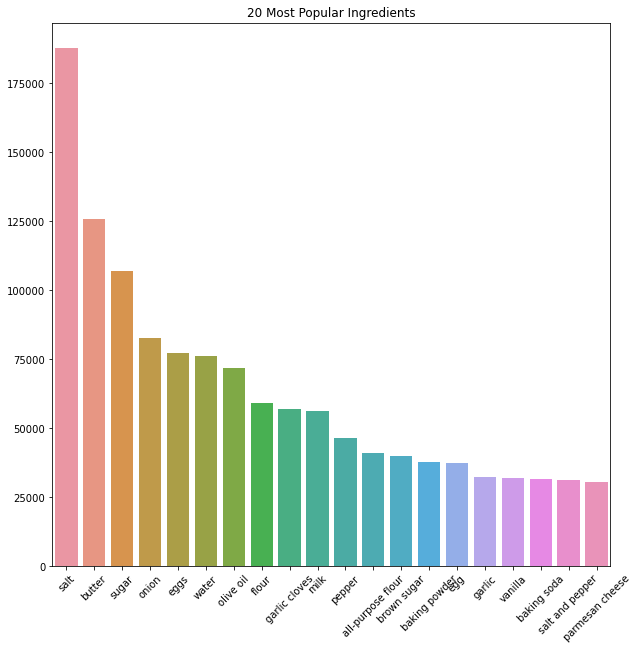

In [13]:

fig, ax = plt.subplots(figsize=(10,10))

# plotting the 20 most frequently used ingredients 
all_plot = sns.barplot(x=ingredients_count.index[:20], y=ingredients_count.values[:20], ax=ax)
plt.xticks(rotation=45);
plt.title('20 Most Popular Ingredients')

Text(0.5, 1.0, '% Recipies w/the 20 Most Popular Ingredients')

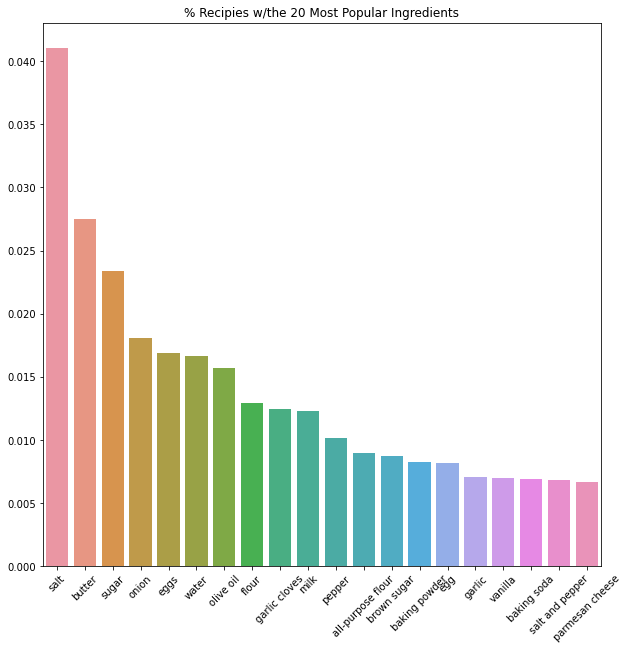

In [14]:

fig, ax = plt.subplots(figsize=(10,10))

# plotting the 20 most frequently used ingredients 
all_plot = sns.barplot(x=ingredients_count.index[:20], y=ingredients_count.values[:20]/ingredients_count.sum(),
                       ax=ax)
plt.xticks(rotation=45);
plt.title('% Recipies w/the 20 Most Popular Ingredients')

Text(0.5, 1.0, '20 Most Popular Search Terms')

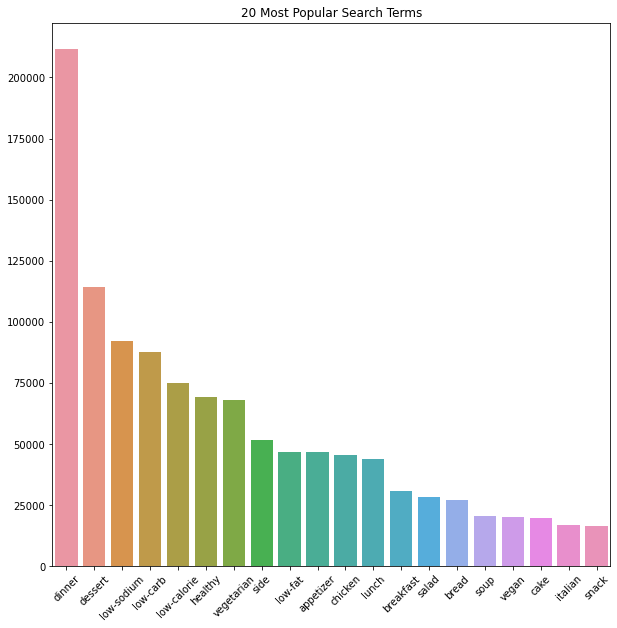

In [15]:
fig, ax = plt.subplots(figsize=(10,10))

# plotting the 20 most frequently used ingredients 
all_plot = sns.barplot(x=search_terms_count.index[:20], y=search_terms_count.values[:20], ax=ax)
plt.xticks(rotation=45);
plt.title('20 Most Popular Search Terms')

Text(0.5, 1.0, '% of Recipes Listed w/ 20 Most Popular Search Terms')

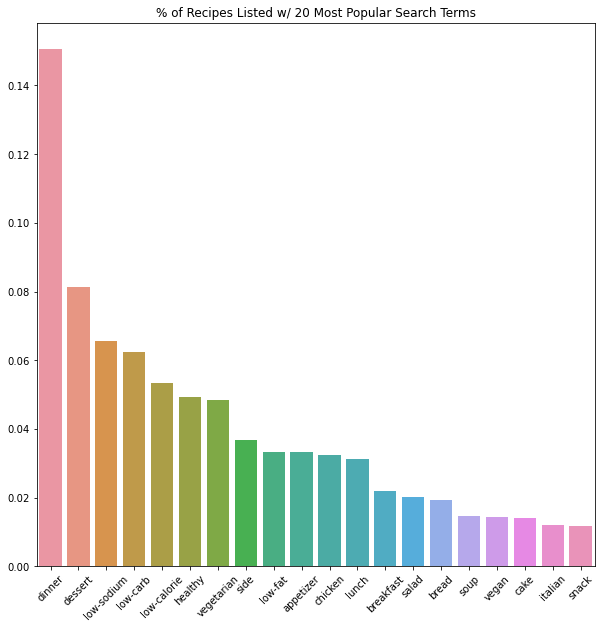

In [16]:

fig, ax = plt.subplots(figsize=(10,10))

# plotting the 20 most frequently used ingredients 
all_plot = sns.barplot(x=search_terms_count.index[:20], y=search_terms_count.values[:20]/search_terms_count.sum(), ax=ax)
plt.xticks(rotation=45);
plt.title('% of Recipes Listed w/ 20 Most Popular Search Terms')

Text(0.5, 1.0, '20 Most Popular Tags')

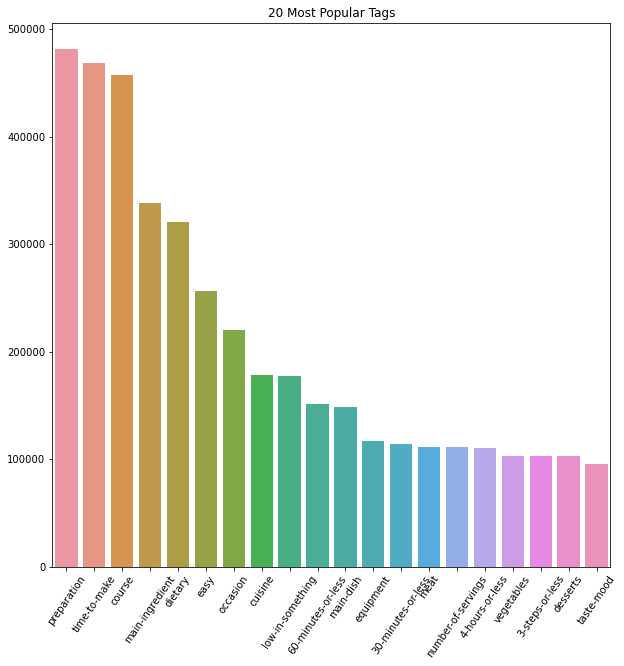

In [17]:

fig, ax = plt.subplots(figsize=(10,10))

# plotting the 20 most frequently used ingredients 
all_plot = sns.barplot(x=tags_count.index[:20], y=tags_count.values[:20], ax=ax)
plt.xticks(rotation=55);
plt.title('20 Most Popular Tags')

In [18]:
easy_ingredient_count = lists_to_count(df[df['target'] == 1], 'ingredients_list', series = True).sort_values(ascending=False)
not_easy_ingredient_count = lists_to_count(df[df['target'] == 0], 'ingredients_list', series = True).sort_values(ascending=False)


<ipython-input-19-f835a0e72603>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(easy_ingredient_count.index[:20])
<ipython-input-19-f835a0e72603>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(not_easy_ingredient_count.index[:20])


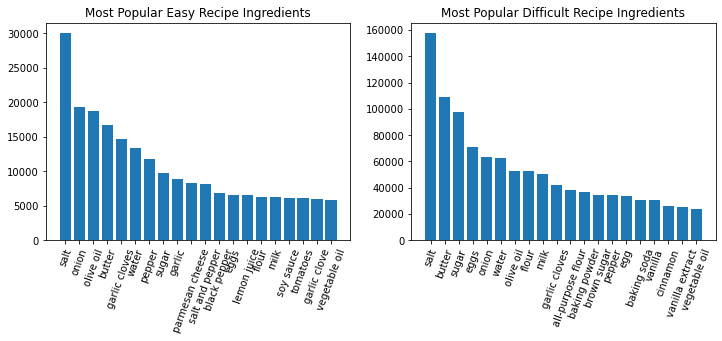

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax[0].bar(easy_ingredient_count.index[:20], easy_ingredient_count.values[:20])
ax[0].set_title('Most Popular Easy Recipe Ingredients')
ax[0].set_xticklabels(easy_ingredient_count.index[:20])
ax[0].tick_params(axis='x', labelrotation=70);

ax[1].bar(not_easy_ingredient_count.index[:20], not_easy_ingredient_count.values[:20])
ax[1].set_title('Most Popular Difficult Recipe Ingredients')
ax[1].set_xticklabels(not_easy_ingredient_count.index[:20])
ax[1].tick_params(axis='x', labelrotation=70);

In [20]:
easy_ingredient_count.sum()

883251

In [21]:
ingredients_count.sum()

4575936

In [22]:
df['target'].value_counts()

0    386689
1     98617
Name: target, dtype: int64

<AxesSubplot:>

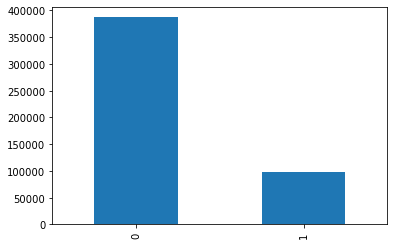

In [25]:
# note the imbalance in the data
df.target.value_counts().plot(kind ='bar')


### Cleaning up and Exploring "Steps"

In [138]:
def basic_cleaning(df, column):
    new_col = 'cleaned_' +column
    # convert to lowercase
    df[new_col] = df[column].apply(lambda x: x.lower())
    
    # remove punctuation and non-characters
    df[new_col] = df[new_col].apply(lambda x: re.sub(r'[^\w\s]','',x))
    df[new_col] = df[new_col].apply(lambda x: re.sub('[0-9\n]',' ',x))

    #strip whitespace
    df[new_col] = df[new_col].apply(lambda x: re.sub('[ ]{2,}',' ',x))
    
    return df

In [ ]:
df = basic_cleaning(df, 'steps')

In [95]:
# # convert to lowercase
# df['cleaned_steps'] = df['steps'].apply(lambda x: x.lower())


# # remove punctuation and non-characters
# df['cleaned_steps'] = df['cleaned_steps'].apply(lambda x: re.sub(r'[^\w\s]','',x))
# df['cleaned_steps'] = df['cleaned_steps'].apply(lambda x: re.sub('[0-9\n]',' ',x))

# #strip whitespace
# df['cleaned_steps'] = df['cleaned_steps'].apply(lambda x: re.sub('[ ]{2,}',' ',x))

In [96]:
step = df['cleaned_steps'][0]

In [97]:
step

'i a sauce pan bring water to a boil slowly add grits and salt stirring constantly reduce heatsimmer uncovered for minutes or untill thickened stirrin occasionally add cheese and garlic stir until cheese is melted spray inch baking dish with nonstick cooking spray cover and refrigerate for to hours or until frim before starting the grill coat the grill rack with nonstick cooking spray cut the grits into inch squares brush both sides with olive oil grill covered over medium heat for to minutes on each side or until lightly browned'

In [98]:
df['step_tokens'] = df['cleaned_steps'].apply(lambda x: x.split())
df.head()

,Unnamed: 0,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,...,ingredients_raw_str_list,steps_list,tags_list,search_terms_list,num_ingredients,num_steps,num_char_description,cleaned_steps,clean_tweet,step_tokens
0,0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...",...,"[4 cups water, 1 cup uncooked old fas...","[I a sauce pan, bring water to a boil; slowly ...","[time-to-make, course, main-ingredient, prepar...","[low-calorie, low-carb, diabetic, vegetarian, ...",6,4,301,i a sauce pan bring water to a boil slowly add...,"['i a sauce pan, bring water to a boil; slowly...","[i, a, sauce, pan, bring, water, to, a, boil, ..."
1,1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...",...,"[1 medium onion, chopped coarse , 1 med...","[In a food processor, pulse the onion, red pep...","[60-minutes-or-less, time-to-make, course, mai...","[shrimp, dinner]",13,10,138,in a food processor pulse the onion red pepper...,"['in a food processor, pulse the onion, red pe...","[in, a, food, processor, pulse, the, onion, re..."
2,3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...",...,"[2 zucchini, sliced , 2 small yello...",[Put all ingredients in the crock pot and cook...,"[weeknight, time-to-make, course, main-ingredi...","[italian, vegetarian, side]",9,1,57,put all ingredients in the crock pot and cook ...,['put all ingredients in the crock pot and coo...,"[put, all, ingredients, in, the, crock, pot, a..."
3,4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",...,"[3 lbs beef stew meat, 3 tablespoons ...","[Preheat oven to 350°F., Cut beef into 1 inch ...","[time-to-make, course, main-ingredient, prepar...",[dinner],14,6,392,preheat oven to f cut beef into inch cubes com...,"['preheat oven to °f.', ""cut beef into inch cu...","[preheat, oven, to, f, cut, beef, into, inch, ..."
4,5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'preparation', 'des...",...,"[12 ounces slivered almonds, 1/4 cup ...",[Preheat oven to 375°F Place almonds in singl...,"[time-to-make, course, preparation, desserts, ...",[dessert],8,4,164,preheat oven to f place almonds in single laye...,['preheat oven to °f place almonds in single l...,"[preheat, oven, to, f, place, almonds, in, sin..."


<ipython-input-141-4c931356e4ca>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(token_count.index[:20])


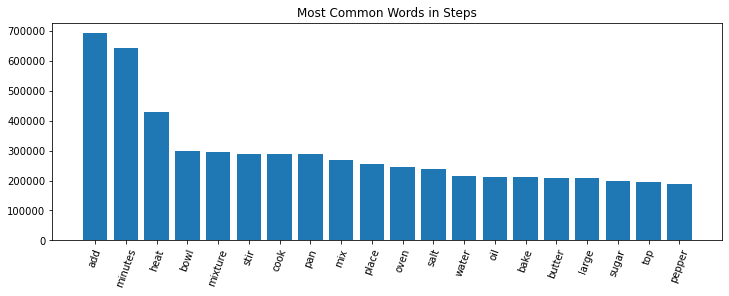

In [141]:
fig, ax = plt.subplots(figsize=(12,4))

ax.bar(token_count.index[:20], token_count.values[:20])
ax.set_title('Most Common Words in Steps')
ax.set_xticklabels(token_count.index[:20])
ax.tick_params(axis='x', labelrotation=70);

In [107]:
#can see this is mostly stopwords - what if we remove those and re-plot

In [108]:
stop_words = stopwords.words('english')
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [134]:
def remove_stop_words(count, stop_words):
    for x in count.index:
        if x in stop_words:
            count = count.drop(x)
    
    return count
        

In [135]:
token_count = remove_stop_words(token_count, stop_words)


<ipython-input-136-8bda3ad61ac2>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(token_count.index[:20])


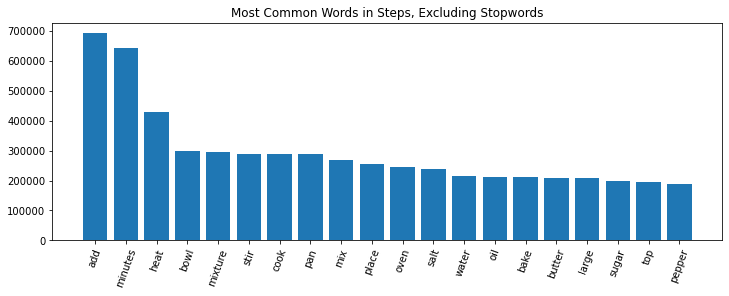

In [136]:
fig, ax = plt.subplots(figsize=(12,4))

ax.bar(token_count.index[:20], token_count.values[:20])
ax.set_title('Most Common Words in Steps, Excluding Stopwords')
ax.set_xticklabels(token_count.index[:20])
ax.tick_params(axis='x', labelrotation=70);

In [139]:
df = basic_cleaning(df, 'description')
df.head()

,Unnamed: 0,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,...,steps_list,tags_list,search_terms_list,num_ingredients,num_steps,num_char_description,cleaned_steps,clean_tweet,step_tokens,cleaned_description
0,0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...",...,"[I a sauce pan, bring water to a boil; slowly ...","[time-to-make, course, main-ingredient, prepar...","[low-calorie, low-carb, diabetic, vegetarian, ...",6,4,301,i a sauce pan bring water to a boil slowly add...,"['i a sauce pan, bring water to a boil; slowly...","[i, a, sauce, pan, bring, water, to, a, boil, ...",we love grits this is another good way to serv...
1,1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...",...,"[In a food processor, pulse the onion, red pep...","[60-minutes-or-less, time-to-make, course, mai...","[shrimp, dinner]",13,10,138,in a food processor pulse the onion red pepper...,"['in a food processor, pulse the onion, red pe...","[in, a, food, processor, pulse, the, onion, re...",simple easy and very tasty for when you are in...
2,3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...",...,[Put all ingredients in the crock pot and cook...,"[weeknight, time-to-make, course, main-ingredi...","[italian, vegetarian, side]",9,1,57,put all ingredients in the crock pot and cook ...,['put all ingredients in the crock pot and coo...,"[put, all, ingredients, in, the, crock, pot, a...",this is a good recipe for weight watchers it i...
3,4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",...,"[Preheat oven to 350°F., Cut beef into 1 inch ...","[time-to-make, course, main-ingredient, prepar...",[dinner],14,6,392,preheat oven to f cut beef into inch cubes com...,"['preheat oven to °f.', ""cut beef into inch cu...","[preheat, oven, to, f, cut, beef, into, inch, ...",this is a fabulous stew that came from one of ...
4,5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'preparation', 'des...",...,[Preheat oven to 375°F Place almonds in singl...,"[time-to-make, course, preparation, desserts, ...",[dessert],8,4,164,preheat oven to f place almonds in single laye...,['preheat oven to °f place almonds in single l...,"[preheat, oven, to, f, place, almonds, in, sin...",this is one of our standard holiday gift recip...


In [140]:
df['description_tokens'] = df['cleaned_description'].apply(lambda x: x.split())
df.head()

,Unnamed: 0,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,...,tags_list,search_terms_list,num_ingredients,num_steps,num_char_description,cleaned_steps,clean_tweet,step_tokens,cleaned_description,description_tokens
0,0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...",...,"[time-to-make, course, main-ingredient, prepar...","[low-calorie, low-carb, diabetic, vegetarian, ...",6,4,301,i a sauce pan bring water to a boil slowly add...,"['i a sauce pan, bring water to a boil; slowly...","[i, a, sauce, pan, bring, water, to, a, boil, ...",we love grits this is another good way to serv...,"[we, love, grits, this, is, another, good, way..."
1,1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...",...,"[60-minutes-or-less, time-to-make, course, mai...","[shrimp, dinner]",13,10,138,in a food processor pulse the onion red pepper...,"['in a food processor, pulse the onion, red pe...","[in, a, food, processor, pulse, the, onion, re...",simple easy and very tasty for when you are in...,"[simple, easy, and, very, tasty, for, when, yo..."
2,3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...",...,"[weeknight, time-to-make, course, main-ingredi...","[italian, vegetarian, side]",9,1,57,put all ingredients in the crock pot and cook ...,['put all ingredients in the crock pot and coo...,"[put, all, ingredients, in, the, crock, pot, a...",this is a good recipe for weight watchers it i...,"[this, is, a, good, recipe, for, weight, watch..."
3,4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",...,"[time-to-make, course, main-ingredient, prepar...",[dinner],14,6,392,preheat oven to f cut beef into inch cubes com...,"['preheat oven to °f.', ""cut beef into inch cu...","[preheat, oven, to, f, cut, beef, into, inch, ...",this is a fabulous stew that came from one of ...,"[this, is, a, fabulous, stew, that, came, from..."
4,5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'preparation', 'des...",...,"[time-to-make, course, preparation, desserts, ...",[dessert],8,4,164,preheat oven to f place almonds in single laye...,['preheat oven to °f place almonds in single l...,"[preheat, oven, to, f, place, almonds, in, sin...",this is one of our standard holiday gift recip...,"[this, is, one, of, our, standard, holiday, gi..."


In [143]:
description_count = lists_to_count(df, 'description_tokens', series = True).sort_values(ascending=False)

<ipython-input-144-b3db4f663f71>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(description_count.index[:20])


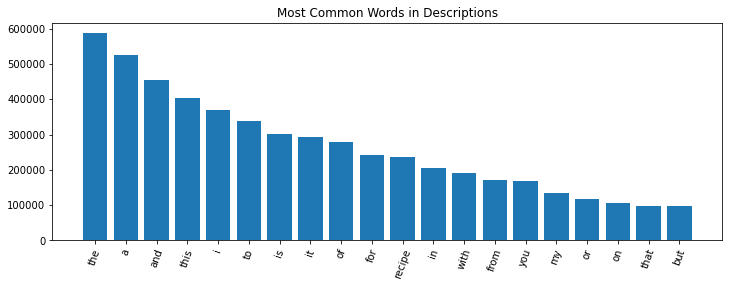

In [144]:
fig, ax = plt.subplots(figsize=(12,4))

ax.bar(description_count.index[:20], description_count.values[:20])
ax.set_title('Most Common Words in Descriptions')
ax.set_xticklabels(description_count.index[:20])
ax.tick_params(axis='x', labelrotation=70);

In [146]:
description_count = remove_stop_words(description_count, stop_words)


<ipython-input-147-335ca2259d43>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(description_count.index[:20])


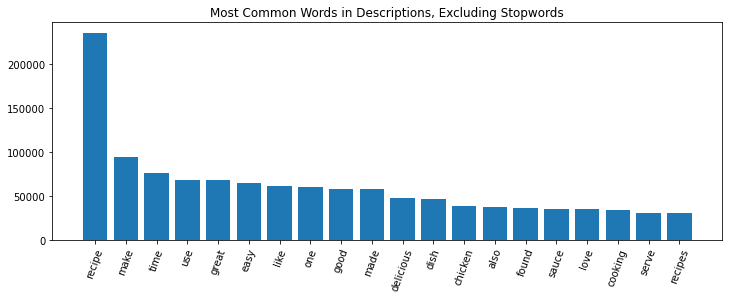

In [147]:
fig, ax = plt.subplots(figsize=(12,4))

ax.bar(description_count.index[:20], description_count.values[:20])
ax.set_title('Most Common Words in Descriptions, Excluding Stopwords')
ax.set_xticklabels(description_count.index[:20])
ax.tick_params(axis='x', labelrotation=70);

In [137]:
# export version of df with tokens
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485306 entries, 0 to 485305
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Unnamed: 0                485306 non-null  int64 
 1   id                        485306 non-null  int64 
 2   name                      485306 non-null  object
 3   description               485306 non-null  object
 4   ingredients               485306 non-null  object
 5   ingredients_raw_str       485306 non-null  object
 6   serving_size              485306 non-null  object
 7   servings                  485306 non-null  int64 
 8   steps                     485306 non-null  object
 9   tags                      485306 non-null  object
 10  search_terms              485306 non-null  object
 11  target_tag                485306 non-null  bool  
 12  target_search_term        485306 non-null  bool  
 13  target                    485306 non-null  int64 
 14  ingr

In [ ]:
df.to_csv('data/data_with_target_tokens.csv')

# Baseline Model  

Need to make sure that you can't just predict the recipe outcome based on the pure numbers - of ingredients, steps, characters, etc...

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485306 entries, 0 to 485305
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Unnamed: 0                485306 non-null  int64 
 1   id                        485306 non-null  int64 
 2   name                      485306 non-null  object
 3   description               485306 non-null  object
 4   ingredients               485306 non-null  object
 5   ingredients_raw_str       485306 non-null  object
 6   serving_size              485306 non-null  object
 7   servings                  485306 non-null  int64 
 8   steps                     485306 non-null  object
 9   tags                      485306 non-null  object
 10  search_terms              485306 non-null  object
 11  target_tag                485306 non-null  bool  
 12  target_search_term        485306 non-null  bool  
 13  target                    485306 non-null  int64 
 14  ingr

In [44]:
# Creating a numbers only db

X_numbers_df = df[['num_ingredients','num_steps', 'num_char_description']]
y_numbers_df = df['target']

In [71]:
# I keep export cells commeneted out until I need them

# X_numbers_df.to_csv('data/X_numbers_only.csv')
# y_numbers_df.to_csv('data/y_numbers_only.csv')